In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn import metrics
import gc

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-parquet/test_data.parquet
/kaggle/input/amex-parquet/train_data.parquet
/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


In [2]:
df1=pd.read_parquet('/kaggle/input/amex-parquet/train_data.parquet')
df1.head()
df1.shape
df_label = pd.read_csv('/kaggle/input/amex-default-prediction/train_labels.csv')
df_label.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [3]:
df1.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827,0


In [4]:
#checking out data types
print(df1.dtypes.value_counts())
list(df1.select_dtypes(['object']).columns)

float32    185
object       4
int64        2
dtype: int64


['customer_ID', 'S_2', 'D_63', 'D_64']

In [5]:
#visualizing columns

#hist = df1.hist(bins=10, figsize = (40,200), layout=(-1,4) )

In [6]:
print(df1.shape[1])
#inspecting NaN
for i in range(len(df1.columns)):
    if (df1.iloc[:,i].isnull().sum()/len(df1) > 0.1):
        print(df1.columns[i], round(df1.iloc[:,i].isnull().sum()/len(df1),2))

#drop columns with high freq of NaN
columns_to_drop = [column for column in df1.columns if df1[column].isnull().sum()/len(df1) >= 0.2]
df1.drop(columns_to_drop, axis=1, inplace=True)
print(df1.shape[1])

191
S_3 0.18
D_42 0.86
D_43 0.3
D_46 0.22
D_48 0.13
D_49 0.9
D_50 0.57
D_53 0.74
S_7 0.18
D_56 0.54
S_9 0.53
D_61 0.11
D_62 0.14
B_17 0.57
D_66 0.89
D_73 0.99
D_76 0.89
D_77 0.45
R_9 0.94
D_82 0.73
B_29 0.93
D_87 1.0
D_88 1.0
D_105 0.55
D_106 0.9
R_26 0.89
D_108 0.99
D_110 0.99
D_111 0.99
B_39 0.99
S_27 0.25
B_42 0.99
D_132 0.9
D_134 0.96
D_135 0.96
D_136 0.96
D_137 0.96
D_138 0.96
D_142 0.83
157


In [7]:
#using only most recent transaction from each customer
temp = df1.shape
df1=df1.set_index(['customer_ID'])
df1=df1.ffill()
df1=df1.bfill()
df1=df1.reset_index()

df1=df1.groupby('customer_ID').tail(1)
df1=df1.set_index(['customer_ID'])

#Drop date column since it is no longer useful
df1.drop(['S_2'],axis=1,inplace=True)

print(temp, df1.shape)

#inspecting NaN
print('Columns left with NaN:')
for i in range(len(df1.columns)):
    if (df1.iloc[:,i].isnull().sum()/len(df1) > 0):
        print(df1.columns[i], round(df1.iloc[:,i].isnull().sum()/len(df1),2))

(5531451, 157) (458913, 155)
Columns left with NaN:


In [8]:
df1.head()
df1 = df1.drop(['target'], axis=1)
keep = df1.columns

In [9]:
print(df1.shape)
# Create correlation matrix
corr_matrix = df1.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features w/ high correl
df1.drop(to_drop, axis=1, inplace=True)

print(df1.shape)


(458913, 154)
(458913, 140)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [10]:
#Removing low variance columns in interest of ram
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

temp = df1.drop(['D_63', 'D_64'], axis=1)

# Initialize and fit the method
vt = VarianceThreshold(threshold = float(0.1))
vt.fit(temp)

#columns with sufficient variance
keep = list(compress(temp.columns, vt.get_support()))

keep.append('D_63')
keep.append('D_64')

df1=df1[keep]

keep.append('customer_ID')
keep.append('S_2')
len(keep)


55

In [11]:
""""
#removing outliers
print(df1.shape)

df1 = df1[df1['R_6'] < df1['R_6'].quantile(0.97)]
print(df1['R_6'].max())
print(df1.shape)"""

'"\n#removing outliers\nprint(df1.shape)\n\ndf1 = df1[df1[\'R_6\'] < df1[\'R_6\'].quantile(0.97)]\nprint(df1[\'R_6\'].max())\nprint(df1.shape)'

In [12]:
"""#df1.iloc[:100000,7].value_counts()
print(df1.iloc[:,1].head())


#What type of variable for dates
df1['S_2'] = pd.to_datetime(df1['S_2'])
df1['S_2'] = pd.to_numeric(df1['S_2'])

#normalizing
#df1['S_2'] = (df1['S_2']-df1['S_2'].min())/(df1['S_2'].max() - df1['S_2'].min())
print(df1['S_2'].head())

df1['S_2'] = pd.to_timedelta(df1['S_2'])
print(df1.iloc[:,1].dt.total_seconds())
"""

"#df1.iloc[:100000,7].value_counts()\nprint(df1.iloc[:,1].head())\n\n\n#What type of variable for dates\ndf1['S_2'] = pd.to_datetime(df1['S_2'])\ndf1['S_2'] = pd.to_numeric(df1['S_2'])\n\n#normalizing\n#df1['S_2'] = (df1['S_2']-df1['S_2'].min())/(df1['S_2'].max() - df1['S_2'].min())\nprint(df1['S_2'].head())\n\ndf1['S_2'] = pd.to_timedelta(df1['S_2'])\nprint(df1.iloc[:,1].dt.total_seconds())\n"

In [13]:
#Hot ones
df1 = pd.get_dummies(df1)
print(df1.shape)
print(df1.columns)
print(df1['D_64_-1'].sum())
df1.drop(['D_64_-1'], axis=1, inplace = True)
print(df1.shape)

(458913, 61)
Index(['D_39', 'B_2', 'B_5', 'D_48', 'B_6', 'B_8', 'B_10', 'S_5', 'S_6',
       'B_12', 'R_5', 'D_60', 'D_61', 'D_65', 'B_16', 'B_18', 'B_20', 'D_68',
       'R_6', 'B_21', 'D_69', 'D_71', 'P_4', 'B_24', 'R_7', 'B_26', 'D_78',
       'R_8', 'S_16', 'R_10', 'D_81', 'R_14', 'D_84', 'B_30', 'R_20', 'S_22',
       'S_23', 'S_26', 'D_103', 'R_27', 'B_38', 'D_112', 'B_40', 'D_114',
       'D_117', 'D_120', 'D_126', 'D_128', 'D_129', 'D_130', 'D_139',
       'D_63_CL', 'D_63_CO', 'D_63_CR', 'D_63_XL', 'D_63_XM', 'D_63_XZ',
       'D_64_-1', 'D_64_O', 'D_64_R', 'D_64_U'],
      dtype='object')
1865
(458913, 60)


In [14]:
#Handling missing values
#my_imputer = SimpleImputer()
#df1.iloc[:,:] = my_imputer.fit_transform(df1.iloc[:,:])

In [15]:
X = df1.iloc[:, :].values.reshape(-1, len(df1.columns))
Y = df_label.iloc[:len(df1), 1].values.reshape(-1, 1)
print('half')
# create object for the class
log = LogisticRegression()
log.fit(X, Y) 
Y_pred = log.predict(X)

print(Y_pred, np.sum(Y_pred))
print(log.score(X, Y))

half


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[0 0 0 ... 0 0 0] 108842
0.876399230355209


Accuracy: 0.876
0.8252981733814853


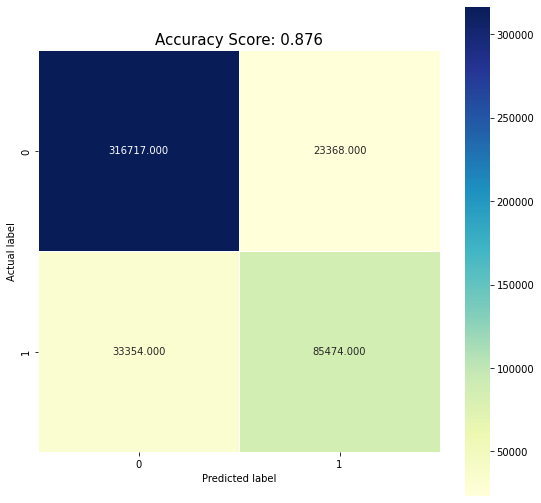

In [16]:
cm = metrics.confusion_matrix(Y, Y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'YlGnBu');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(log.score(X, Y),3))
plt.title(all_sample_title, size = 15);

print('Accuracy:',round(metrics.accuracy_score(Y, Y_pred),3))
metrics.roc_curve(Y, Y_pred)
print(metrics.roc_auc_score(Y, Y_pred))

In [17]:
#free up ram
del df1, df_label, cm
gc.collect()

4905

In [18]:
#run prediction on test data

print(len(keep))
#need to only load some columns due to ram limitations
df2=pd.read_parquet('/kaggle/input/amex-parquet/test_data.parquet', columns =keep)
print(df2.shape)




55
(11363762, 55)


In [19]:
#Handling missing values via imputation
#df2.iloc[:,:] = my_imputer.fit_transform(df2.iloc[:,:])

In [20]:
#using only most recent transaction from each customer
#Does this make sense for test data??
temp = df2.shape
df2=df2.set_index(['customer_ID'])
df2=df2.ffill()
df2=df2.bfill()
df2=df2.reset_index()

df2=df2.groupby('customer_ID').tail(1)
df2=df2.set_index(['customer_ID'])

#Drop date column since it is no longer useful
df2.drop(['S_2'],axis=1,inplace=True)

print(temp, df2.shape)

#inspecting NaN
print('Columns left with NaN:')
for i in range(len(df2.columns)):
    if (df2.iloc[:,i].isnull().sum()/len(df2) > 0):
        print(df2.columns[i], round(df2.iloc[:,i].isnull().sum()/len(df2),2))

(11363762, 55) (924621, 53)
Columns left with NaN:


In [21]:
#hot ones
df2 = pd.get_dummies(df2)
print(df2.shape)
print(df2.columns)

(924621, 60)
Index(['D_39', 'B_2', 'B_5', 'D_48', 'B_6', 'B_8', 'B_10', 'S_5', 'S_6',
       'B_12', 'R_5', 'D_60', 'D_61', 'D_65', 'B_16', 'B_18', 'B_20', 'D_68',
       'R_6', 'B_21', 'D_69', 'D_71', 'P_4', 'B_24', 'R_7', 'B_26', 'D_78',
       'R_8', 'S_16', 'R_10', 'D_81', 'R_14', 'D_84', 'B_30', 'R_20', 'S_22',
       'S_23', 'S_26', 'D_103', 'R_27', 'B_38', 'D_112', 'B_40', 'D_114',
       'D_117', 'D_120', 'D_126', 'D_128', 'D_129', 'D_130', 'D_139',
       'D_63_CL', 'D_63_CO', 'D_63_CR', 'D_63_XL', 'D_63_XM', 'D_63_XZ',
       'D_64_O', 'D_64_R', 'D_64_U'],
      dtype='object')


In [22]:
df2.head()

,D_39,B_2,B_5,D_48,B_6,B_8,B_10,S_5,S_6,B_12,...,D_139,D_63_CL,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_64_O,D_64_R,D_64_U
customer_ID,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,0.121385,1.009347,0.050187,0.517214,0.024945,1.008730,0.033599,0.011795,0.003473,0.058696,...,0.005912,0,0,1,0,0,0,0,0,1
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,0.126475,1.009245,0.135907,0.041712,0.182720,1.008640,0.298735,0.009336,0.005253,0.054184,...,0.004344,0,1,0,0,0,0,1,0,0
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,0.002724,0.810072,0.004851,0.522954,0.058534,1.009375,0.129189,0.004455,0.001847,0.052914,...,1.001246,0,0,1,0,0,0,0,0,1
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,0.324828,0.205678,0.022947,0.602520,0.023546,0.009775,0.032124,0.320184,0.008872,0.098741,...,1.008246,1,0,0,0,0,0,0,1,0
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,0.768016,0.038021,0.011126,0.959607,0.011244,1.006200,0.022026,0.064127,0.009401,0.016391,...,0.006623,0,1,0,0,0,0,0,1,0


In [23]:
X = df2.iloc[:, :].values.reshape(-1, len(df2.columns))

Y_pred2 = log.predict(X)
print(Y_pred2)

df2 = df2.reset_index()

final = pd.DataFrame({"customer_ID":df2.customer_ID,"prediction":Y_pred2})

final.to_csv('submission.csv', index=False)
print(Y_pred2, np.sum(Y_pred2))

[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0] 222724


In [24]:
final.to_csv('submission.csv', index=False)
print(final)

                                              customer_ID  prediction
0       00000469ba478561f23a92a868bd366de6f6527a684c9a...           0
1       00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...           0
2       0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...           0
3       00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...           0
4       00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...           1
...                                                   ...         ...
924616  ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...           0
924617  ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...           0
924618  ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...           0
924619  ffffddef1fc3643ea179c93245b68dca0f36941cd83977...           1
924620  fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...           0

[924621 rows x 2 columns]
